# Initialize the Environment

In [72]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
#os.environ['MKL_NUM_THREADS'] = '1'
import sys
import glob
import json
import subprocess
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import scipy.sparse as sp
import scipy.signal as sig
from sklearn import manifold
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
from Codebase.Networks.SubgraphDetection.nonnegfac import nmf
os.chdir('./Analysis_Notebooks/')

path_MetaData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Raw_Neocortical'
path_CoreData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Dyne_Neocortical/FuncConn.XCorr_WideBand.4_115/network'
path_PeriphData = '/home1/a/ankk/LittHome/Remotes/RSRCH.InterictalSubgraph'
path_InpData_Cons = path_PeriphData + '/ds-e03-NMF_Consensus'
path_InpData_Cocl = path_PeriphData + '/ds-e04-NMF_CoCluster'
path_ExpData = path_PeriphData + '/ds-e06-Subgraph_Topology'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Data List

In [73]:
# Get clinical_metadata
df_meta = h5py.File('{}/clinical_metadata.mat'.format(path_MetaData), 'r')
meta_subj = [''.join(unichr(c) for c in df_meta[r])
             for r in df_meta['subject']['ID'][:, 0]]


subj_dict = {}
for subj_ii, subj_id in enumerate(meta_subj):        
    print('{}'.format(subj_id))
    
    # Grab Channel information
    try:
        ref = df_meta['subject']['Channels'][subj_ii, 0]
        chan_lbl = [''.join(unichr(c) for c in df_meta[rr]) \
                    for rr in df_meta[ref][0, :]]
        ref = df_meta['subject']['Channels_Spike'][subj_ii, 0]
        spk_lbl = [''.join(unichr(c) for c in df_meta[rr]) \
                    for rr in df_meta[ref][0, :]]
    except:
        continue

    # Find ictal epochs
    ictal_path = np.sort(glob.glob('{}/{}/{}-ictal-block-*.mat'.format(
                path_MetaData, subj_id, subj_id)))
    
    # Find SOZ/NSOZ Channels
    soz_list = []
    nsoz_list = []
    for pth in ictal_path:
        df_signal = h5py.File(pth, 'r')
    
        if len(df_signal['channels_soz'].shape) < 2:
            continue
        soz_lbl = [''.join(unichr(c) for c in df_signal[r]) \
                    for r in df_signal['channels_soz'][0, :]]
        soz_idx = np.array(
            [chan_idx for chan_idx in xrange(len(chan_lbl)) \
                if chan_lbl[chan_idx] in soz_lbl])
        for ix in soz_idx:
            soz_list.append(ix)
    soz_list = np.unique(soz_list)
    if len(soz_list) < 2:
        print('No SOZ')
        continue
    if len(soz_list) == len(chan_lbl):
        print('Diffuse Onset')
        continue
    nsoz_list = np.setdiff1d(np.arange(len(chan_lbl)),
                             soz_list)
    
    # Find SPK/NSPK Channels
    spk_list = []
    nspk_list = []

    spk_idx = np.array(
        [chan_idx for chan_idx in xrange(len(chan_lbl)) \
         if chan_lbl[chan_idx] in spk_lbl])
    for ix in spk_idx:
        spk_list.append(ix)
    spk_list = np.unique(spk_list)
    if len(spk_list) < 2:
        print('No SPK')
        continue
    nspk_list = np.setdiff1d(np.arange(len(chan_lbl)),
                             spk_list)
    
    
    # Get the block and cluster assignments
    try:
        block_subg = np.load('{}/NMF_Subgraph_Ensemble.{}.npz'.format(path_InpData_Cocl, subj_id))['subg_ensemble_matr']
        block_subg_null = np.load('{}/NMF_Subgraph_Ensemble.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['subg_ensemble_matr']
        block_expr = np.load('{}/NMF_Subgraph_Ensemble.{}.npz'.format(path_InpData_Cocl, subj_id))['expr_ensemble_matr']
        
        block_epoch = np.load('{}/NMF_Subgraph_Ensemble.{}.npz'.format(path_InpData_Cocl, subj_id))['block_ensemble_matr']
        block_epoch_null = np.load('{}/NMF_Subgraph_Ensemble.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['block_ensemble_matr']
        
        clust = np.load('{}/NMF_Subgraph_States.{}.npz'.format(path_InpData_Cocl, subj_id))['states']
        clust_null = np.load('{}/NMF_Subgraph_States.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['states']
        
        block_locs = np.load('{}/NMF_Subgraph_Projection.{}.npz'.format(path_InpData_Cocl, subj_id))['block_locs']        
        block_locs_null = np.load('{}/NMF_Subgraph_Projection.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['block_locs']        
    except IOError:
        continue
        
    subj_dict[subj_id] = {}
    subj_dict[subj_id]['Real_Cluster'] = {}
    subj_dict[subj_id]['Null_Cluster'] = {}    
        
    subj_dict[subj_id]['Real_Cluster']['epoch_subg'] = block_subg
    subj_dict[subj_id]['Null_Cluster']['epoch_subg'] = block_subg_null
    subj_dict[subj_id]['Real_Cluster']['epoch_expr'] = block_expr
    
    subj_dict[subj_id]['Real_Cluster']['epoch_full_lbl'] = block_epoch
    subj_dict[subj_id]['Null_Cluster']['epoch_full_lbl'] = block_epoch_null
    
    subj_dict[subj_id]['Real_Cluster']['epoch_lbl'] = np.array([epoch_str.split('.')[1] for epoch_str in block_epoch])
    subj_dict[subj_id]['Null_Cluster']['epoch_lbl'] = np.array([epoch_str.split('.')[1] for epoch_str in block_epoch_null])

    subj_dict[subj_id]['Real_Cluster']['epoch_id'] = np.unique(subj_dict[subj_id]['Real_Cluster']['epoch_lbl'])  
    subj_dict[subj_id]['Null_Cluster']['epoch_id'] = np.unique(subj_dict[subj_id]['Null_Cluster']['epoch_lbl'])
    
    subj_dict[subj_id]['Real_Cluster']['clust_lbl'] = clust
    subj_dict[subj_id]['Null_Cluster']['clust_lbl'] = clust_null

    subj_dict[subj_id]['Real_Cluster']['clust_id'] = np.unique(clust)
    subj_dict[subj_id]['Null_Cluster']['clust_id'] = np.unique(clust_null)
    
    subj_dict[subj_id]['Real_Cluster']['n_clust'] = len(subj_dict[subj_id]['Real_Cluster']['clust_id'])
    subj_dict[subj_id]['Null_Cluster']['n_clust'] = len(subj_dict[subj_id]['Null_Cluster']['clust_id'])    
        
    subj_dict[subj_id]['Real_Cluster']['projection'] = block_locs
    subj_dict[subj_id]['Null_Cluster']['projection'] = block_locs_null  
    
    subj_dict[subj_id]['SOZ_Channels'] = soz_list
    subj_dict[subj_id]['NSOZ_Channels'] = nsoz_list    
    subj_dict[subj_id]['SPK_Channels'] = spk_list
    subj_dict[subj_id]['NSPK_Channels'] = nspk_list    

n_subj = len(subj_dict.keys())
subj_key = np.sort(subj_dict.keys())    

HUP64
HUP65
HUP68
HUP70
No SOZ
HUP72
HUP73
HUP78
No SOZ
HUP79
HUP86
HUP87
MAYO004
MAYO006
MAYO010
MAYO011
MAYO012
No SOZ
MAYO014
No SOZ
MAYO016
MAYO019
MAYO020
MAYO023
MAYO026
MAYO028
No SOZ
MAYO030
MAYO031
MAYO033
Diffuse Onset
MAYO037


# Plot Real and Null Subgraphs

(u'MAYO023', 'MAYO023.interictal.358')


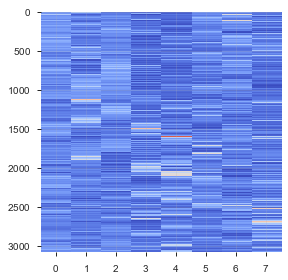

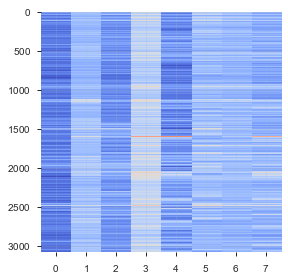

In [83]:
%matplotlib inline

subj_id = np.random.permutation(subj_dict.keys())[0]
epoch_lbl = np.random.permutation(np.unique(subj_dict[subj_id]['Real_Cluster']['epoch_full_lbl']))[0]
epoch_ix = np.flatnonzero(subj_dict[subj_id]['Real_Cluster']['epoch_full_lbl'] == epoch_lbl)

print(subj_id, epoch_lbl)

real_subg = subj_dict[subj_id]['Real_Cluster']['epoch_subg'][epoch_ix, :]
null_subg = subj_dict[subj_id]['Null_Cluster']['epoch_subg'][epoch_ix, :]

n_fac = np.float(real_subg.shape[0])
n_conn = np.float(real_subg.shape[1])

plt.figure()
ax = plt.subplot(111)
mat = ax.matshow(real_subg.T, aspect=n_fac/n_conn, cmap='coolwarm')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.savefig('./e06-Figures/Subgraph_Cfg_Matr.Real.svg')

plt.figure()
ax = plt.subplot(111)
mat = ax.matshow(null_subg.T, aspect=n_fac/n_conn, cmap='coolwarm')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.savefig('./e06-Figures/Subgraph_Cfg_Matr.Null.svg')

# Plot Consensus Similarity Matrix

In [6]:
%matplotlib inline

subj_id = 'MAYO023' #np.random.permutation(subj_dict.keys())[0]

df_real = np.load('{}/NMF_Subgraph_Similarity.{}.npz'.format(path_InpData_Cocl, subj_id))
df_null = np.load('{}/NMF_Subgraph_Similarity.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))
clust_real = subj_dict[subj_id]['Real_Cluster']['clust_lbl']
clust_null = subj_dict[subj_id]['Null_Cluster']['clust_lbl']


sim_matr = []
for df, clust in [(df_real, clust_real),
                  (df_null, clust_null)]:
    M = sp.csr_matrix((df['M_data'], df['M_indices'], df['M_indptr']), shape=df['M_shape']).A
    
    # Reorder by cluster assignment
    clust_ix = np.argsort(clust)
    M = M[clust_ix, :][:, clust_ix]
    sim_matr.append(M)

plt.figure()
ax = plt.subplot(111)
mat = ax.matshow(sim_matr[0], cmap='coolwarm')
ax.set_axis_off()
plt.savefig('./e06-Figures/Subgraph_Similarity.Real.svg')
plt.close()

plt.figure()
ax = plt.subplot(111)
mat = ax.matshow(sim_matr[1], cmap='coolwarm')
ax.set_axis_off()
plt.savefig('./e06-Figures/Subgraph_Similarity.Null.svg')
plt.close()

# SOZ Sensitivity Index

In [13]:
def sensitivity_index(adj, in_chan, out_chan):

    ix, iy = np.mgrid[0:len(in_chan), 0:len(in_chan)]
    in_conn = adj[in_chan[ix], in_chan[iy]]
    in_conn_str = np.sum(in_conn) / (len(in_chan)*(len(in_chan)-1))

    ix, iy = np.mgrid[0:len(out_chan), 0:len(out_chan)]
    out_conn = adj[out_chan[ix], out_chan[iy]]
    out_conn_str = np.sum(out_conn) / (len(out_chan)*(len(out_chan)-1))

    sens_index = (in_conn_str - out_conn_str) / (in_conn_str + out_conn_str)
    
    return sens_index

                
data_table = {'Subject': [],
              'Model': [],
              'Epoch': [],
              'Block_Ix': [],
              'Cluster_ID': [], 
              'Expr_Energy': [],
              'Expr_Skew': [],
              'Sens_Index': [],
              'Sens_Index_Null': [],
              'Spk_Sens_Index': [],
              'Spk_Sens_Index_Null': []}

for subj_ii, subj_id in enumerate(subj_key):
    print(subj_id)
    
    soz_chan = subj_dict[subj_id]['SOZ_Channels']
    nsoz_chan = subj_dict[subj_id]['NSOZ_Channels']    
    spk_chan = subj_dict[subj_id]['SPK_Channels']
    nspk_chan = subj_dict[subj_id]['NSPK_Channels']        

    for model_id in ['Real_Cluster']:        
        for epoch_id in ['ictal', 'interictal']:
            
            ep_ix = np.flatnonzero(subj_dict[subj_id][model_id]['epoch_lbl'] == epoch_id)
            for pt_ix in ep_ix:

                # Cluster ID for the sample
                cl_id = subj_dict[subj_id][model_id]['clust_lbl'][pt_ix]

                # Subgraph for the sample
                expr = subj_dict[subj_id][model_id]['epoch_expr'][pt_ix]
                expr /= expr.max()
                subg = subj_dict[subj_id][model_id]['epoch_subg'][pt_ix]
                adj = conv_cfg_vec_to_adj_matr(subg) 
                
                # Permute the channel labels
                rnd_chan_perm = np.random.permutation(adj.shape[0])
                soz_chan_null = rnd_chan_perm[:len(soz_chan)]
                nsoz_chan_null = rnd_chan_perm[len(soz_chan):]

                # Compute True and Null Sensitivity Index
                sens_index_true = sensitivity_index(adj, soz_chan, nsoz_chan)
                sens_index_null = sensitivity_index(adj, soz_chan_null, nsoz_chan_null)    

                # Permute the channel labels
                rnd_chan_perm = np.random.permutation(adj.shape[0])
                spk_chan_null = rnd_chan_perm[:len(spk_chan)]
                nspk_chan_null = rnd_chan_perm[len(spk_chan):]

                # Compute True and Null Sensitivity Index
                spk_sens_index_true = sensitivity_index(adj, spk_chan, nspk_chan)
                spk_sens_index_null = sensitivity_index(adj, spk_chan_null, nspk_chan_null)    
                
                # Compute Expression Skew
                expr_energy = np.mean(expr**2)
                expr_skew = stats.skew(expr)


                data_table['Subject'].append(subj_id)
                data_table['Model'].append(model_id)
                data_table['Epoch'].append(epoch_id)
                data_table['Block_Ix'].append(pt_ix)
                data_table['Cluster_ID'].append(cl_id)
                data_table['Expr_Energy'].append(expr_energy)
                data_table['Expr_Skew'].append(expr_skew)                    
                data_table['Sens_Index'].append(sens_index_true)
                data_table['Sens_Index_Null'].append(sens_index_null)
                data_table['Spk_Sens_Index'].append(spk_sens_index_true)
                data_table['Spk_Sens_Index_Null'].append(spk_sens_index_null)

# Save Data Table for R-stats
df = pd.DataFrame(data_table, columns=data_table.keys())
df.to_csv('./e06-R_Stats/soz_activation.csv')

HUP64
HUP65
HUP68
HUP72
HUP73
HUP79
HUP86
HUP87
MAYO004
MAYO010
MAYO011
MAYO016
MAYO019
MAYO020
MAYO023
MAYO031
MAYO037


# Ranked SOZ Sensitivity Cluster

In [76]:
df = pd.read_csv('./e06-R_Stats/soz_activation.csv')
df_grp = df.groupby([df['Subject'], df['Epoch'], df['Cluster_ID']]).mean().unstack()

df['New_Cluster_ID'] = np.nan

for (subj_id, epoch_id), sel in df_grp.T.iterkv():
    if not epoch_id == 'interictal':
        continue

    cl_id = subj_dict[subj_id]['Real_Cluster']['clust_id']
    srt_cluster_id = cl_id[np.argsort(sel['Sens_Index'][cl_id])[::-1]]
    
    for id_new, id_orig in enumerate(srt_cluster_id):
        df.loc[(df['Subject'] == subj_id) & (df['Cluster_ID'] == id_orig), 'New_Cluster_ID'] = id_new
        
df['New_Cluster_ID'] = df['New_Cluster_ID'].astype(int)

# Save Data Table for R-stats
df.to_csv('./e06-R_Stats/soz_activation.csv')

/mnt/castor/seas_home/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: iterkv is deprecated and will be removed in a future release, use ``iteritems`` instead.


## Plot SOZ Sensitivity Ranking

Ttest_relResult(statistic=7.5659738516366746, pvalue=1.1346934832406358e-06)
(0.3110846506811959, 0.040220660531942662)
(-0.019833714709019859, 0.0055941549437858139)
 
Ttest_relResult(statistic=5.540950458310463, pvalue=4.4729747546721578e-05)
(0.14893581696594516, 0.028619141130096139)
(-0.013135500193591484, 0.0035937592336859592)
 
Ttest_relResult(statistic=4.2500132916638291, pvalue=0.00061117477047162121)
(0.094997471441007231, 0.024462735598747922)
(-0.015896628753096508, 0.0048460638614199348)
 
Ttest_relResult(statistic=1.9339078421466489, pvalue=0.071013951697560446)
(0.027653363177137031, 0.020292158384563882)
(-0.015825339847958791, 0.0048428995111118789)
 
Ttest_relResult(statistic=-0.87839409002275948, pvalue=0.39273019121976893)
(-0.037766014407335763, 0.020063843677925113)
(-0.018573573762420088, 0.0057085411791610906)
 
Ttest_relResult(statistic=-3.3638922735081005, pvalue=0.0039498628295308435)
(-0.089484838825899291, 0.019889029699330908)
(-0.017180264074857576, 0.00

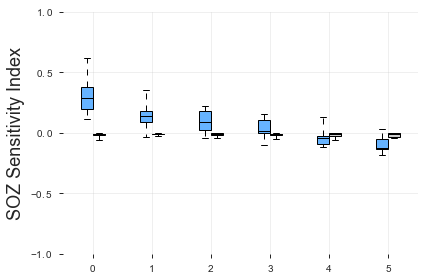

Ttest_relResult(statistic=2.1534668134355508, pvalue=0.046878211678765241)
(0.11698396948432063, 0.24143203479942793, 0.058555869463872944)
(-0.014129275226887996, 0.021141739495564041, 0.0051276250029119513)
 
Ttest_relResult(statistic=1.4121366350625093, pvalue=0.17706352087245039)
(0.035343684160806063, 0.14029438438875108, 0.034026386206813301)
(-0.015728708154732943, 0.025813528885338749, 0.0062607003625990689)
 
Ttest_relResult(statistic=0.40949933603063676, pvalue=0.68760309625334037)
(-0.00020797889927947851, 0.14203059647061231, 0.034447479489283145)
(-0.014546354282123135, 0.017629708921939317, 0.0042758324725911687)
 
Ttest_relResult(statistic=0.49458210351577658, pvalue=0.62761722901959627)
(0.0035926058994126312, 0.14136018878031806, 0.034284881741088465)
(-0.013497180076941824, 0.018007727463517951, 0.0043675154358482652)
 
Ttest_relResult(statistic=-0.00058672569300218295, pvalue=0.99953911381783356)
(-0.013289021627150259, 0.12762411253450523, 0.030953393903263522)
(-0.

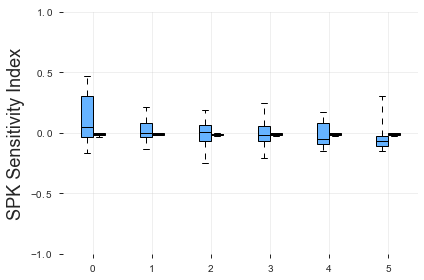

In [88]:
df = pd.read_csv('./e06-R_Stats/soz_activation.csv')
sel_epoch = df[df['Epoch'] == 'interictal']
n_clust = 6

%matplotlib inline
color = {'Sens_Index_Null': [0.8, 0.8, 0.8],
         'Sens_Index': [0.4, 0.7, 1]}
        
### PLOT SOZ Sensitivity
plt.figure()
ax = plt.subplot(111)

oneway = []
for clust_ii, clust_id in enumerate(np.arange(n_clust)):
    sel_clust = sel_epoch[sel_epoch['New_Cluster_ID'] == clust_id]
    sel_sens_index = sel_clust['Sens_Index'].groupby(sel_clust['Subject']).mean()
    sel_sens_index_null = sel_clust['Sens_Index_Null'].groupby(sel_clust['Subject']).mean()
    
    bplot = ax.boxplot([sel_sens_index, sel_sens_index_null], 
                       positions=[clust_ii-0.1, clust_ii+0.1],
                       widths=[0.2, 0.2], whis=[5, 95],
                       patch_artist=True)
    fig_plotting.set_box_color(bplot, 'k', [color['Sens_Index'],
                                            color['Sens_Index_Null']])

    oneway.append(list(sel_sens_index))
    print(stats.ttest_rel(sel_sens_index, sel_sens_index_null))
    print(sel_sens_index.mean(), sel_sens_index.std()/np.sqrt(len(sel_sens_index)))
    print(sel_sens_index_null.mean(), sel_sens_index_null.std()/np.sqrt(len(sel_sens_index_null)))
    print(' ')
print('SOZ ANOVA: {}'.format(stats.f_oneway(oneway[0], oneway[1], oneway[2], oneway[3], oneway[4], oneway[5])))
    
ax.set_xlim([-0.5, clust_ii+0.5])        
plt.xticks(np.arange(n_clust),
           np.arange(n_clust))
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([-1.0, 1.0])        
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('SOZ Sensitivity Index')

plt.savefig('./e06-Figures/SOZ_Sensitive_Cluster.svg')
plt.show()



### PLOT SPK Sensitivity
plt.figure()
ax = plt.subplot(111)

oneway = []
for clust_ii, clust_id in enumerate(np.arange(n_clust)):
    sel_clust = sel_epoch[sel_epoch['New_Cluster_ID'] == clust_id]
    sel_sens_index = sel_clust['Spk_Sens_Index'].groupby(sel_clust['Subject']).mean()
    sel_sens_index_null = sel_clust['Spk_Sens_Index_Null'].groupby(sel_clust['Subject']).mean()
    
    bplot = ax.boxplot([sel_sens_index, sel_sens_index_null], 
                       positions=[clust_ii-0.1, clust_ii+0.1],
                       widths=[0.2, 0.2], whis=[5, 95],
                       patch_artist=True)
    fig_plotting.set_box_color(bplot, 'k', [color['Sens_Index'],
                                            color['Sens_Index_Null']])
    
    oneway.append(list(sel_sens_index))
    print(stats.ttest_rel(sel_sens_index, sel_sens_index_null))
    print(sel_sens_index.mean(), sel_sens_index.std(), sel_sens_index.std()/np.sqrt(len(sel_sens_index)))
    print(sel_sens_index_null.mean(), sel_sens_index_null.std(), sel_sens_index_null.std()/np.sqrt(len(sel_sens_index_null)))
    print(' ')
print('SPK ANOVA: {}'.format(stats.f_oneway(oneway[0], oneway[1], oneway[2], oneway[3], oneway[4], oneway[5])))

ax.set_xlim([-0.5, clust_ii+0.5])        
plt.xticks(np.arange(n_clust),
           np.arange(n_clust))
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([-1.0, 1.0])        
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('SPK Sensitivity Index')

plt.savefig('./e06-Figures/SPK_Sensitive_Cluster.svg')
plt.show()

## Plot Expression-Based SOZ Sensitivity Prediction

Ttest_relResult(statistic=-3.3428429798452552, pvalue=0.00412913060337625)
(0.1668583121118995, 0.011961801947485152)
(0.20386815191609053, 0.0049337793571736796)
 
Ttest_relResult(statistic=0.33108189626983242, pvalue=0.74487909851243428)
(0.20566436453780532, 0.021203225630029129)
(0.19881162223934101, 0.004378966544939353)
 
Ttest_relResult(statistic=0.63132935215496711, pvalue=0.53674101016202824)
(0.2074149181556903, 0.014473928018646842)
(0.195759780839314, 0.0069279105192722405)
 
Ttest_relResult(statistic=-0.16142098425331608, pvalue=0.87378256801685084)
(0.19572473968921941, 0.018280843406344331)
(0.1988632400752732, 0.0056096975825973613)
 
Ttest_relResult(statistic=-1.2083637373303626, pvalue=0.24446406075476312)
(0.18698200090141981, 0.011591342739696513)
(0.20083747662167001, 0.0055138212240625241)
 
Ttest_relResult(statistic=1.3331967384632195, pvalue=0.20113975599875841)
(0.22673501937039597, 0.021550996389406128)
(0.19644185964187022, 0.005325893552028887)
 


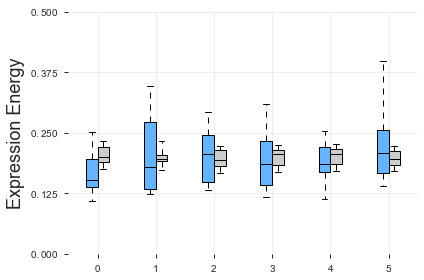

In [75]:
df = pd.read_csv('./e06-R_Stats/soz_activation.csv')
sel_epoch = df[df['Epoch'] == 'interictal']
n_clust = 6

%matplotlib inline
color = {'Expr_Altr': [0.8, 0.8, 0.8],
         'Expr_Main': [0.4, 0.7, 1]}
        
plt.figure()
ax = plt.subplot(111)

for clust_ii, clust_id in enumerate(np.arange(n_clust)):
    sel_clust_main = sel_epoch[sel_epoch['New_Cluster_ID'] == clust_id]
    sel_clust_altr = sel_epoch[sel_epoch['New_Cluster_ID'] != clust_id]    
    
    sel_expr_main = sel_clust_main['Expr_Energy'].groupby(df['Subject']).mean()
    sel_expr_altr = sel_clust_altr['Expr_Energy'].groupby(df['Subject']).mean()    
        
    bplot = ax.boxplot([sel_expr_main, sel_expr_altr],
                       positions=[clust_ii-0.1, clust_ii+0.1],
                       widths=[0.2, 0.2], whis=[5, 95],
                       patch_artist=True)
    fig_plotting.set_box_color(bplot, 'k', [color['Expr_Main'],
                                            color['Expr_Altr']])

    print(stats.ttest_rel(sel_expr_main, sel_expr_altr))
    print(sel_expr_main.mean(), sel_expr_main.std()/np.sqrt(len(sel_expr_main)))
    print(sel_expr_altr.mean(), sel_expr_altr.std()/np.sqrt(len(sel_expr_altr)))
    print(' ')
    

    
ax.set_xlim([-0.5, clust_ii+0.5])        
plt.xticks(np.arange(n_clust),
           np.arange(n_clust))
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([0.0, 0.5])        
ax.set_yticks(np.linspace(0.0, 0.5, 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Expression Energy')

plt.savefig('./e06-Figures/SOZ_Sensitive_Predict.svg')
plt.show()

## Plot Cluster Subgraphs

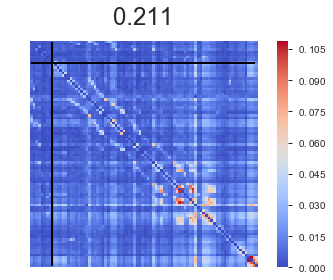

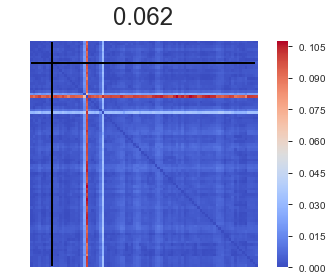

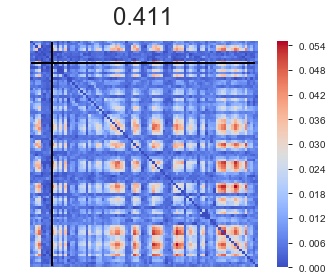

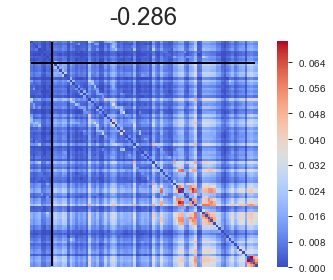

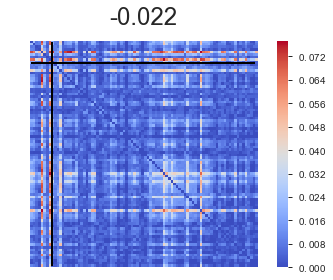

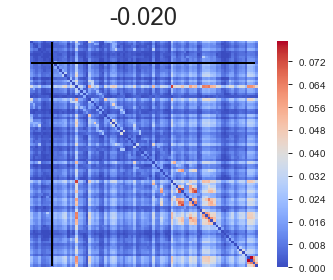

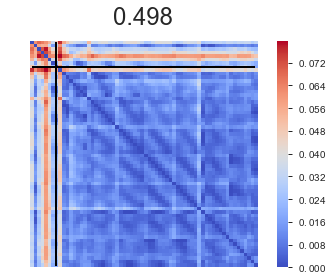

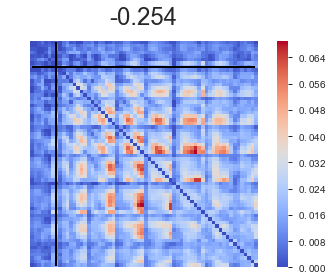

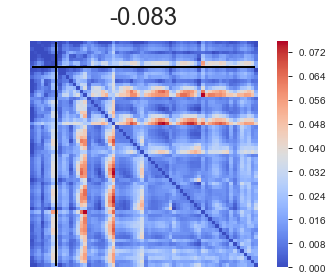

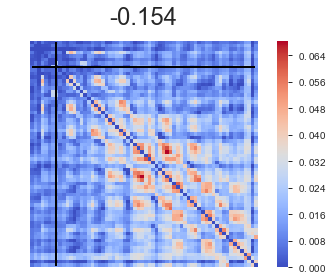

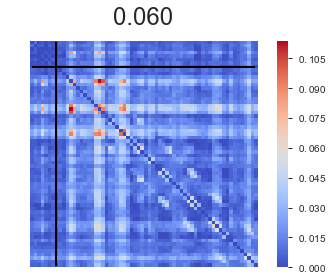

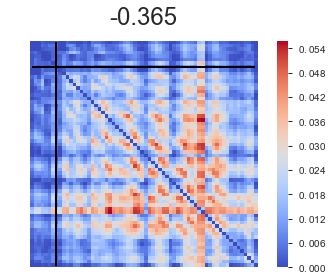

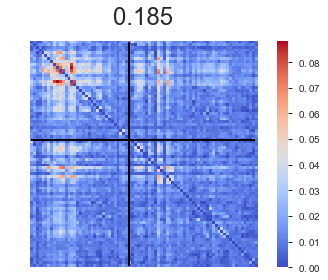

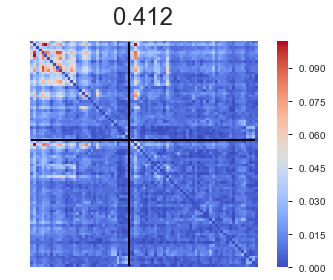

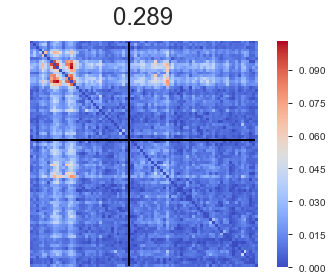

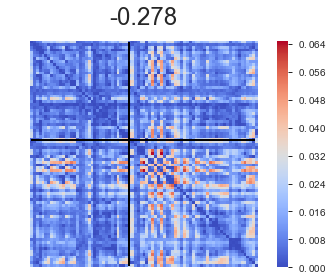

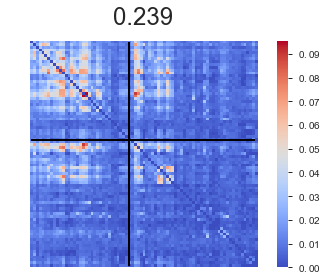

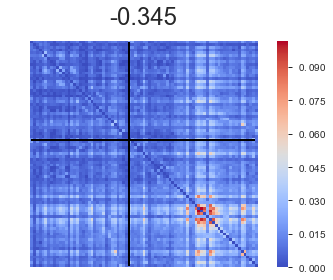

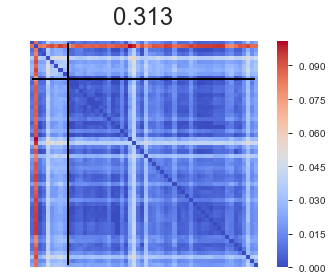

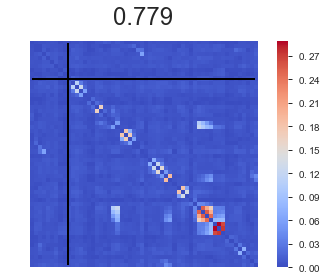

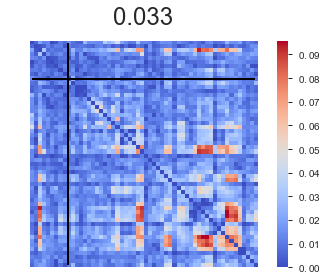

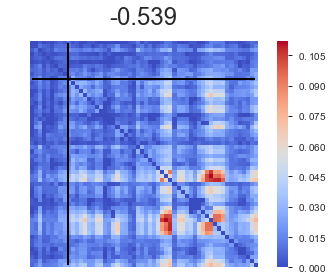

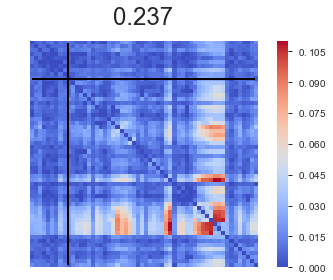

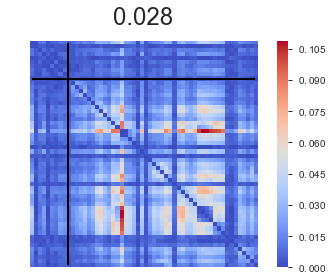

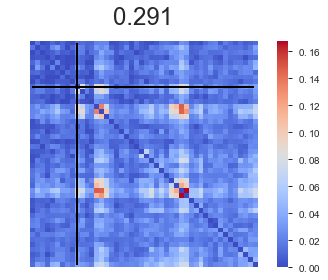

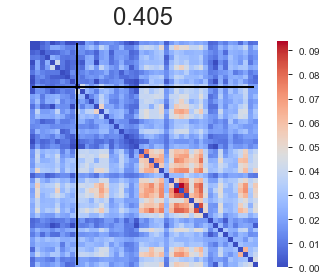

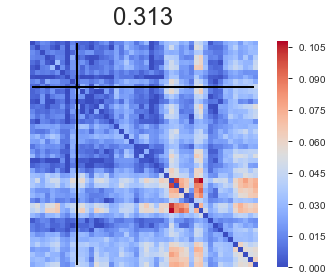

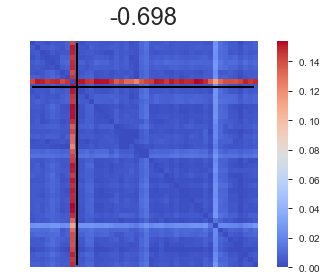

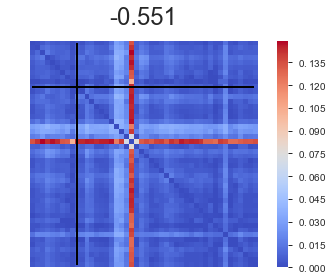

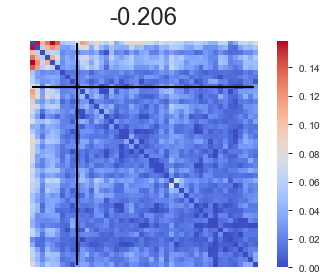

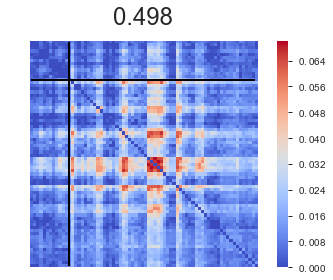

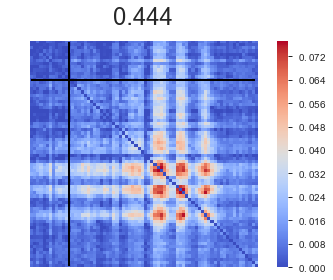

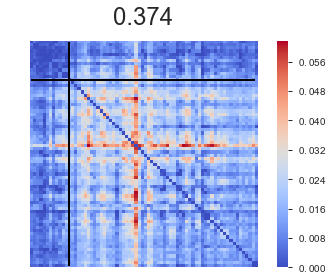

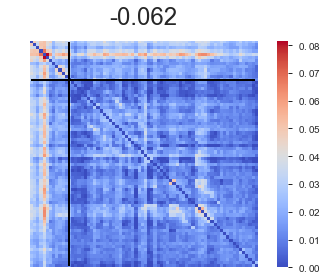

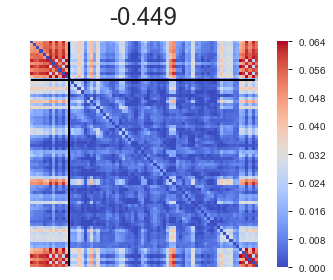

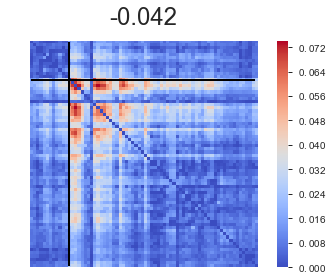

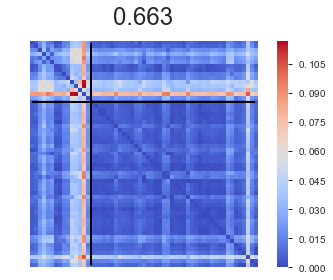

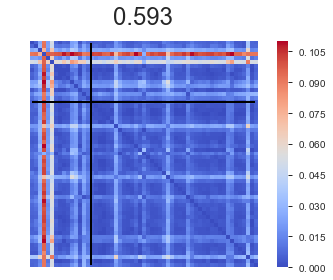

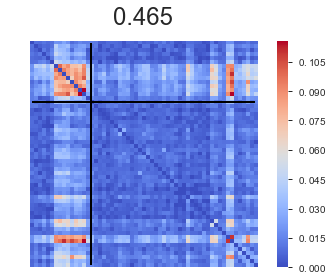

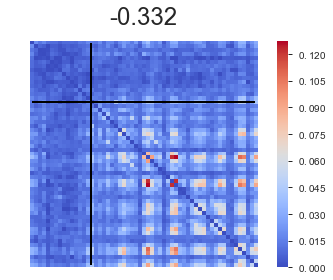

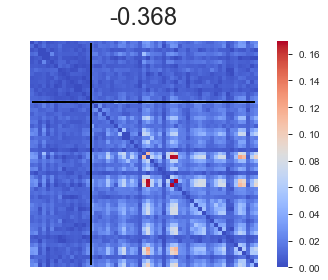

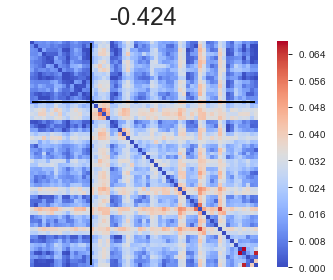

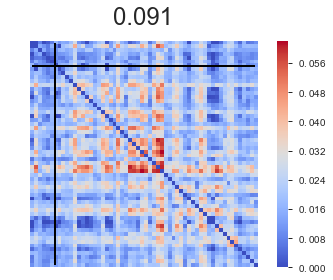

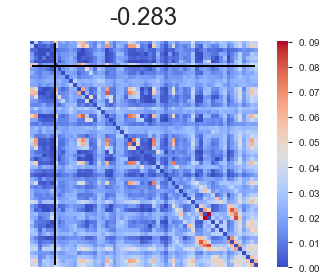

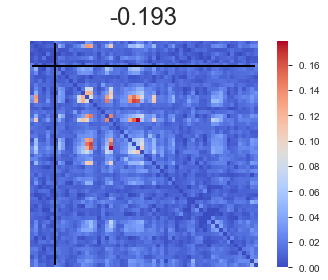

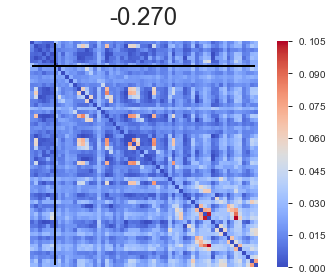

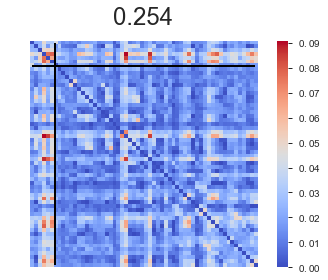

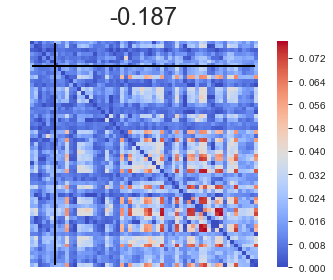

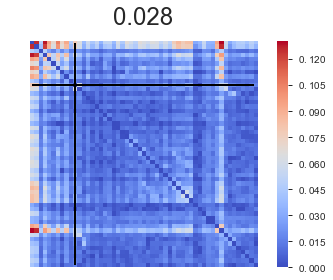

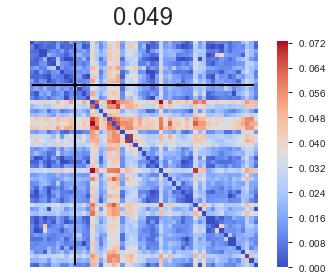

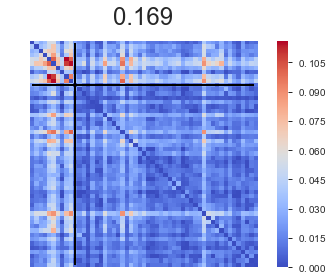

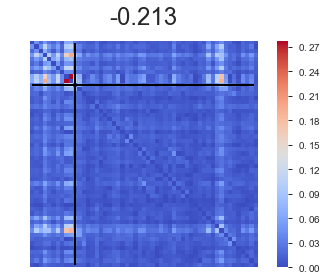

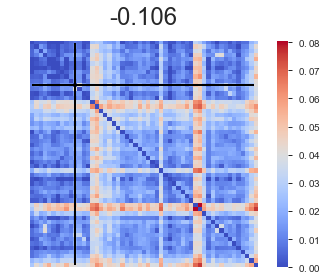

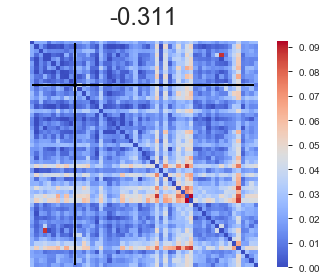

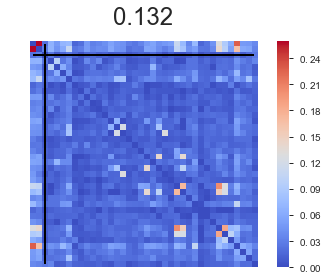

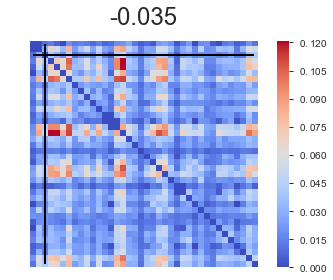

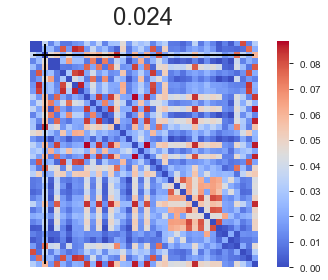

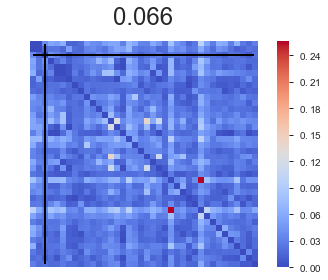

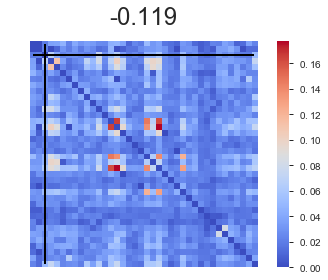

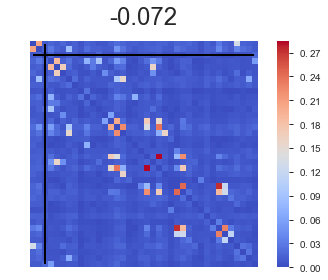

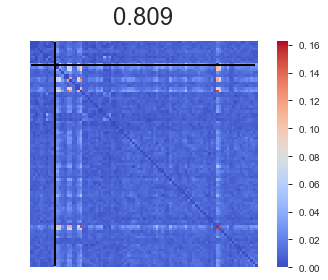

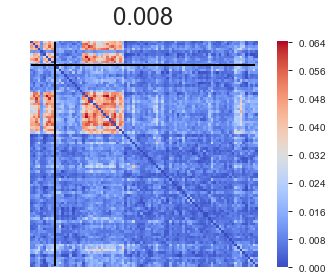

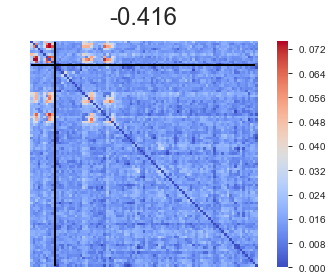

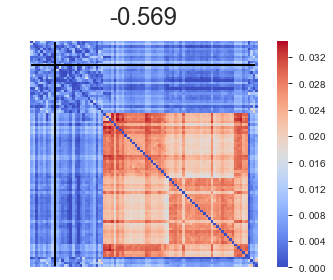

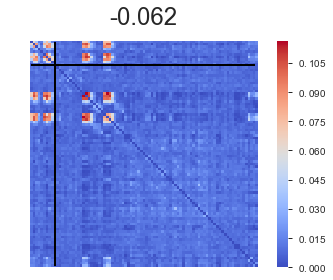

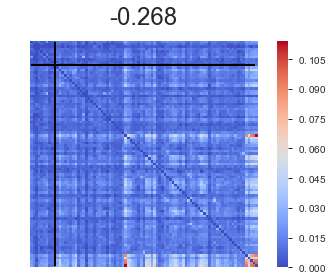

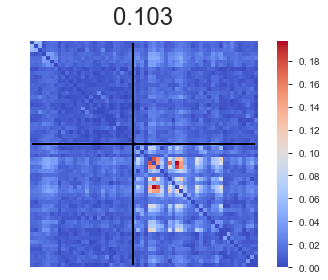

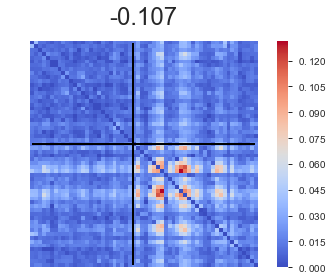

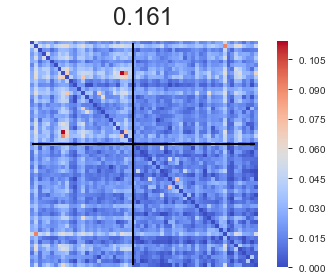

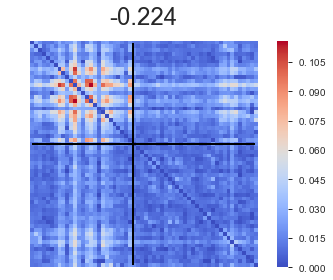

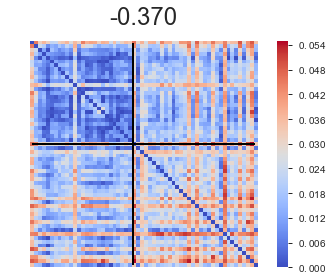

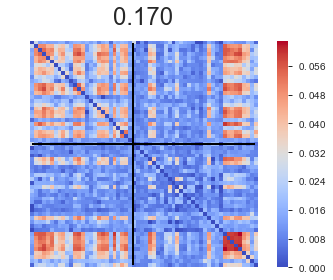

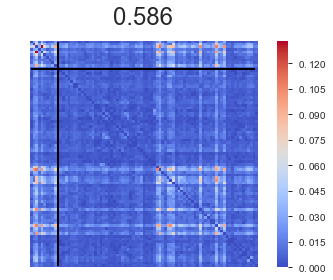

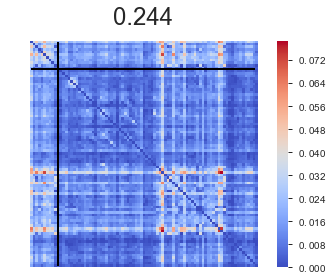

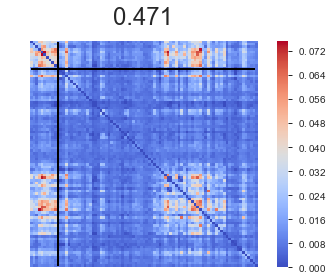

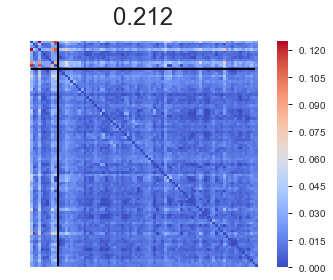

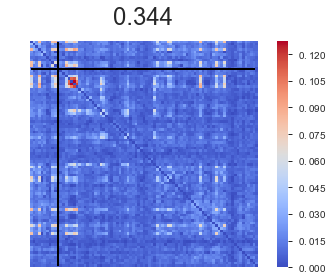

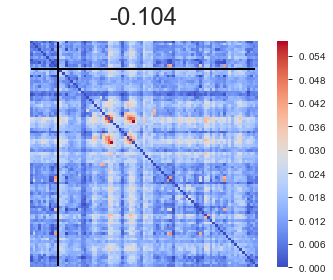

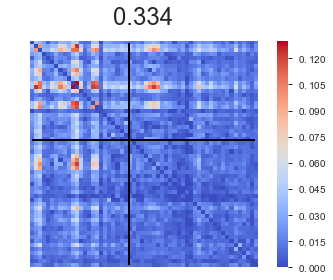

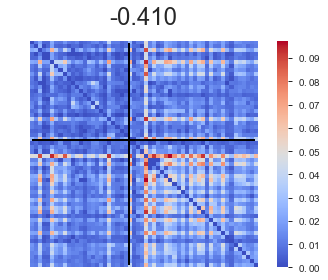

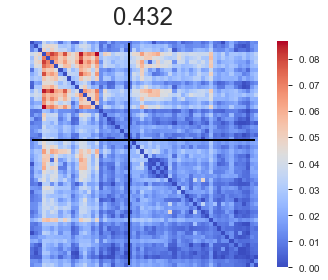

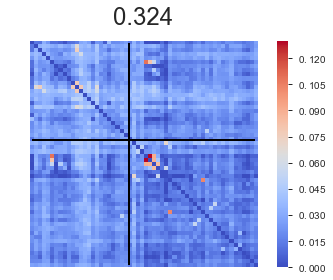

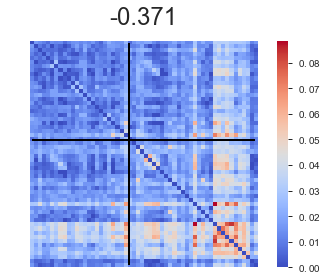

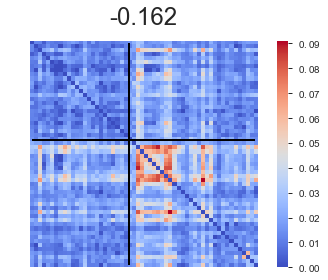

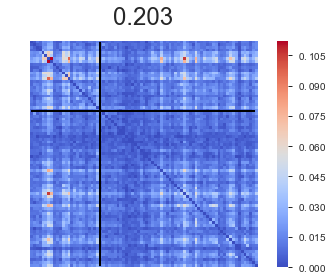

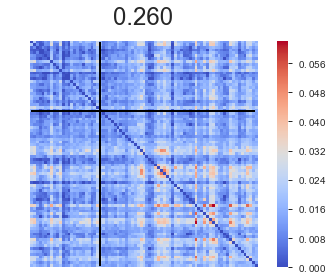

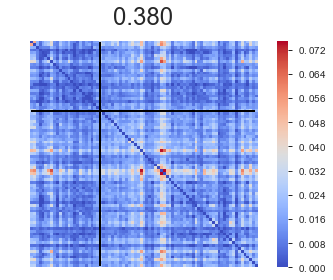

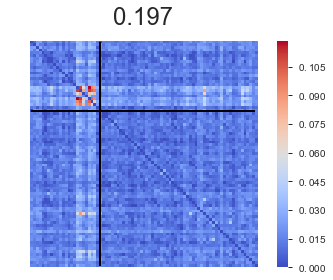

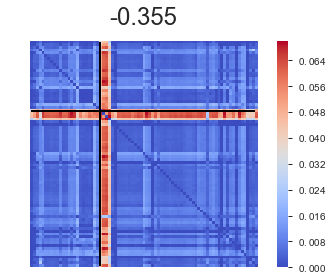

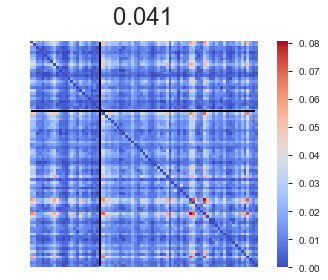

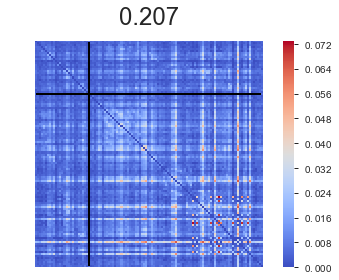

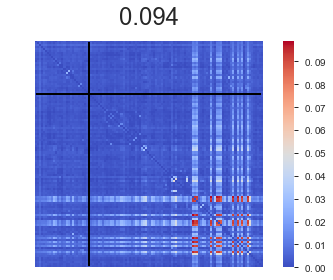

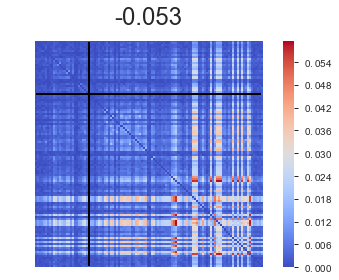

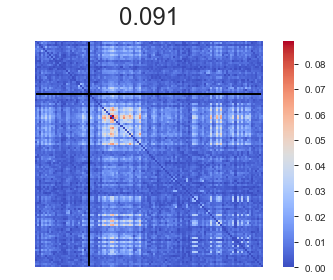

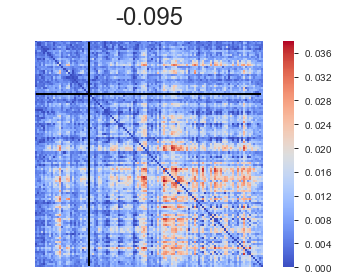

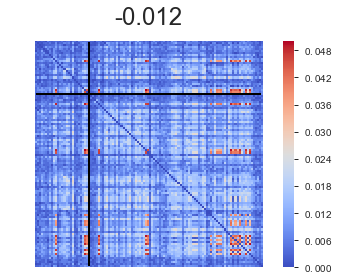

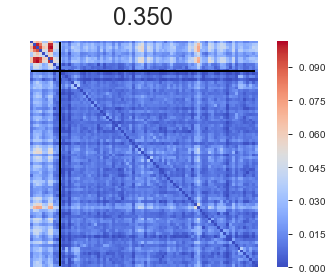

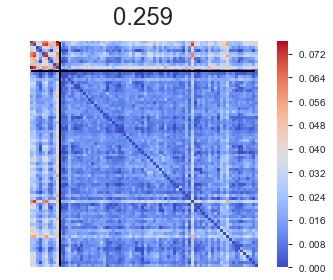

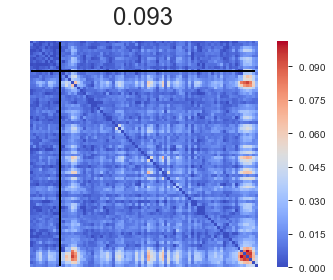

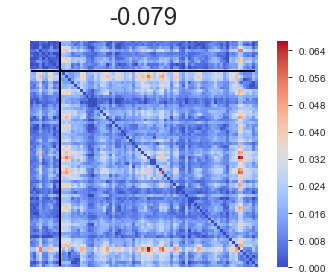

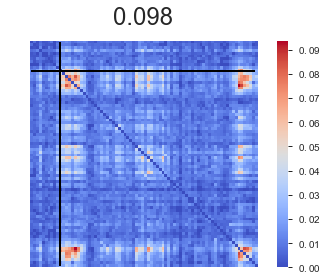

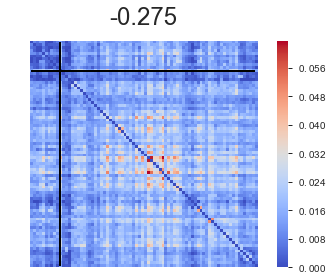

In [71]:
df = pd.read_csv('./e06-R_Stats/soz_activation.csv')
sel_model = df[df['Model'] == 'Real_Cluster']
sel_epoch = sel_model[df['Epoch'] == 'interictal']
n_clust = 6

%matplotlib inline        

for subj_ii, subj_id in enumerate(np.unique(df['Subject'])):
    sel_subj = sel_epoch[sel_epoch['Subject'] == subj_id]

    for clust_id in xrange(n_clust):
        sel_clust_new = sel_subj[sel_subj['New_Cluster_ID'] == clust_id]
        
        # Median Cluster Index
        med_ix = np.argmax(np.abs(sel_clust_new['Sens_Index']))
        block_ix = sel_clust_new.ix[med_ix].Block_Ix

        # Subgraph
        subg = subj_dict[subj_id]['Real_Cluster']['epoch_subg'][block_ix]
        adj = conv_cfg_vec_to_adj_matr(subg)
        chan_ix = np.concatenate((subj_dict[subj_id]['SOZ_Channels'],
                                  subj_dict[subj_id]['NSOZ_Channels']))
        
        plt.figure()
        ax = plt.subplot(111)
        mat = ax.matshow(adj[:, chan_ix][chan_ix, :], cmap='coolwarm')
        ax.vlines(len(subj_dict[subj_id]['SOZ_Channels']), 0, adj.shape[0]-1)
        ax.hlines(len(subj_dict[subj_id]['SOZ_Channels']), 0, adj.shape[0]-1)
        plt.colorbar(mat, ax=ax)
        ax.set_title('%0.3f' % sel_clust_new.ix[med_ix].Sens_Index)
        ax.set_axis_off()
        plt.savefig('./e06-Figures/Subgraph.Cluster_{}.{}.svg'.format(clust_id+1, subj_id))
        plt.close()

## Plot Cluster Expression

In [120]:
df = pd.read_csv('./e06-R_Stats/soz_activation.csv')
sel_model = df[df['Model'] == 'Real_Cluster']
sel_epoch = sel_model[df['Epoch'] == 'interictal']
n_clust = 6

pct = [33, 66]

%matplotlib inline        

for subj_ii, subj_id in enumerate(np.unique(df['Subject'])):
    sel_subj = sel_epoch[sel_epoch['Subject'] == subj_id]

    expr_matr = []

    # Expression (Low Energy / Low Skew)
    med_ix = np.flatnonzero((sel_subj['Expr_Energy'] < np.percentile(sel_subj['Expr_Energy'], pct[0])) &
                            (sel_subj['Expr_Skew'] < np.percentile(sel_subj['Expr_Skew'], pct[0])))
    try:
        block_ix = sel_subj.iloc[med_ix[0]].Block_Ix
        expr_matr.append(subj_dict[subj_id]['Real_Cluster']['epoch_expr'][block_ix])
    except:
        continue

    # Expression (High Energy / Low Skew)
    med_ix = np.flatnonzero((sel_subj['Expr_Energy'] > np.percentile(sel_subj['Expr_Energy'], pct[1])) &
                            (sel_subj['Expr_Skew'] < np.percentile(sel_subj['Expr_Skew'], pct[0])))
    try:
        block_ix = sel_subj.iloc[med_ix[0]].Block_Ix
        expr_matr.append(subj_dict[subj_id]['Real_Cluster']['epoch_expr'][block_ix])
    except:
        continue
    
    # Expression (Low Energy / High Skew)
    med_ix = np.flatnonzero((sel_subj['Expr_Energy'] < np.percentile(sel_subj['Expr_Energy'], pct[0])) &
                            (sel_subj['Expr_Skew'] > np.percentile(sel_subj['Expr_Skew'], pct[1])))
    try:
        block_ix = sel_subj.iloc[med_ix[0]].Block_Ix
        expr_matr.append(subj_dict[subj_id]['Real_Cluster']['epoch_expr'][block_ix])
    except:
        continue

    # Expression (High Energy / High Skew)
    med_ix = np.flatnonzero((sel_subj['Expr_Energy'] > np.percentile(sel_subj['Expr_Energy'], pct[1])) &
                            (sel_subj['Expr_Skew'] > np.percentile(sel_subj['Expr_Skew'], pct[1])))
    try:
        block_ix = sel_subj.iloc[med_ix[0]].Block_Ix
        expr_matr.append(subj_dict[subj_id]['Real_Cluster']['epoch_expr'][block_ix])
    except:
        continue
    
    plt.figure()
    ax = plt.subplot(111)
    for expr_ii, expr in enumerate(expr_matr):
        expr_norm = np.convolve(expr / expr.max(), np.ones(10)/10., mode='valid')
        
        ax.plot(np.arange(expr_norm.shape[0]),
                expr_norm)

    ax.set_ylim([0, 1])
    #ax.set_xlim([0, 300])
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.savefig('./e06-Figures/Expression.Cluster.{}.svg'.format(subj_id))
    plt.close()

## Plot Expression Dynamics Between Clusters

Ttest_relResult(statistic=0.9031450909313461, pvalue=0.38072407979706202)
(1.7005164232473462, 0.25306760946887652)
(1.3439740200860939, 0.24331869659955396)
 
Ttest_relResult(statistic=2.1206318158503392, pvalue=0.048102608921257929)
(1.2542262977332308, 0.24441211493714454)
(0.74861782106966113, 0.19612272791154223)
 


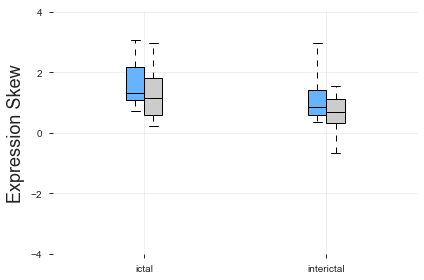

In [40]:
df = pd.read_csv('./e06-R_Stats/soz_activation.csv')
n_clust = 6

%matplotlib inline
color = {'Expr_Altr': [0.8, 0.8, 0.8],
         'Expr_Main': [0.4, 0.7, 1]}

data_table = {'Epoch': [],
              'Cluster_ID': [],
              'Skew': []}

plt.figure()
ax = plt.subplot(111)

for epoch_ii, epoch_id in enumerate(np.unique(df['Epoch'])):
    sel_epoch = df[df['Epoch'] == epoch_id]
    
    sel_clust_sens = sel_epoch[sel_epoch['New_Cluster_ID'] == 0]
    sel_clust_invsens = sel_epoch[sel_epoch['New_Cluster_ID'] == 5]
    
    sel_expr_sens = sel_clust_sens['Expr_Skew'].groupby(df['Subject']).mean()
    sel_expr_invsens = sel_clust_invsens['Expr_Skew'].groupby(df['Subject']).mean()  
        
    bplot = ax.boxplot([sel_expr_sens, sel_expr_invsens],
                       positions=[epoch_ii-0.05, epoch_ii+0.05],
                       widths=[0.1, 0.1], whis=[5, 95],
                       patch_artist=True)
    fig_plotting.set_box_color(bplot, 'k', [color['Expr_Main'],
                                            color['Expr_Altr']])

    print(stats.ttest_rel(sel_expr_sens, sel_expr_invsens))
    print(sel_expr_sens.mean(), sel_expr_sens.std()/np.sqrt(len(sel_expr_sens)))
    print(sel_expr_invsens.mean(), sel_expr_invsens.std()/np.sqrt(len(sel_expr_invsens)))
    print(' ')

    
ax.set_xlim([-0.5, epoch_ii+0.5])        
plt.xticks(np.arange(len(np.unique(df['Epoch']))),
           np.unique(df['Epoch']))
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([-4, 4])        
ax.set_yticks(np.linspace(-4, 4, 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Expression Skew')

plt.savefig('./e06-Figures/SOZ_Sensitive_Skew_both_epochs.svg')
plt.show()

Ttest_relResult(statistic=2.1206318158503392, pvalue=0.048102608921257929)


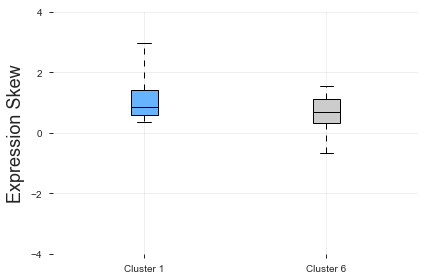

In [39]:
df = pd.read_csv('./e06-R_Stats/soz_activation.csv')
n_clust = 6

%matplotlib inline
color = {'Expr_Altr': [0.8, 0.8, 0.8],
         'Expr_Main': [0.4, 0.7, 1]}

data_table = {'Epoch': [],
              'Cluster_ID': [],
              'Skew': []}

plt.figure()
ax = plt.subplot(111)

sel_epoch = df[df['Epoch'] == 'interictal']

sel_clust_sens = sel_epoch[sel_epoch['New_Cluster_ID'] == 0]
sel_clust_invsens = sel_epoch[sel_epoch['New_Cluster_ID'] == 5]

sel_expr_sens = sel_clust_sens['Expr_Skew'].groupby(df['Subject']).mean()
sel_expr_invsens = sel_clust_invsens['Expr_Skew'].groupby(df['Subject']).mean()  

bplot = ax.boxplot([sel_expr_sens, sel_expr_invsens],
                   positions=[0, 1],
                   widths=[0.15, 0.15], whis=[5, 95],
                   patch_artist=True)
fig_plotting.set_box_color(bplot, 'k', [color['Expr_Main'],
                                        color['Expr_Altr']])

print(stats.ttest_rel(sel_expr_sens, sel_expr_invsens))
print(sel_expr_main.mean(), sel_expr_main.std()/np.sqrt(len(sel_expr_main)))
print(sel_expr_altr.mean(), sel_expr_altr.std()/np.sqrt(len(sel_expr_altr)))
print(' ')

    
ax.set_xlim([-0.5, 1.5])        
plt.xticks([0, 1],
           ['Cluster 1', 'Cluster 6'])
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([-4, 4])        
ax.set_yticks(np.linspace(-4, 4, 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Expression Skew')

plt.savefig('./e06-Figures/SOZ_Sensitive_Skew.svg')
plt.show()